# ROOT LOCUS ANALYSIS PART 2: PID Design

This notebook introduces the root locus plot and its application to control design.
The notebook extends the root locus to PID design assuming that the design objective is
to minimize the dominant pole and minimize oscillations.

# Preliminaries

In [1]:
#!pip install -q control


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control
from typing import List, Tuple, Optional

In [3]:
TIMES = np.linspace(0, 10, 100)

# Helpers

## plotStep

In [14]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    times, yv = control.step_response(tf)
    ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [5]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [6]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [20]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"OL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"OL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# Brief Review of Root Locus Analysis

## Motivation

In [8]:
# An alternative way to construct a transfer function by specifying:
#    zeros, poles, multiplier times the transfer function
OL_TF = control.zpk([], [-2], [5])
OL_TF

TransferFunction(array([5.]), array([1., 2.]))

Let $G(s)$ be the open loop transfer function and $H(s)$ be the closed loop transfer function for p-control.
That is, $C(s) = k_P$. Consider the first order system $G(s) = \frac{k}{s - p}$.
\begin{eqnarray}
H(s) & = & \frac{C(s) G(s)}{1 + C(s) G(s)} \\
 & = & \frac{k_P k}{s - p + k_P k} \\
\end{eqnarray}

The root locus plot displays the poles of the *closed loop* transfer function for the open loop under p-control.
* x-axis is the real part of the pole
* y-axis is the imaginary part of the pole
* Open loop poles are indicated by an "X"
* Open loop zeros are indicated by a red circle
* Blue lines are "branches" the path of closed loop poles as $k_P$ is changed

<Axes: title={'center': 'poles: -2 zeros: 1'}, xlabel='Real', ylabel='Imaginary'>

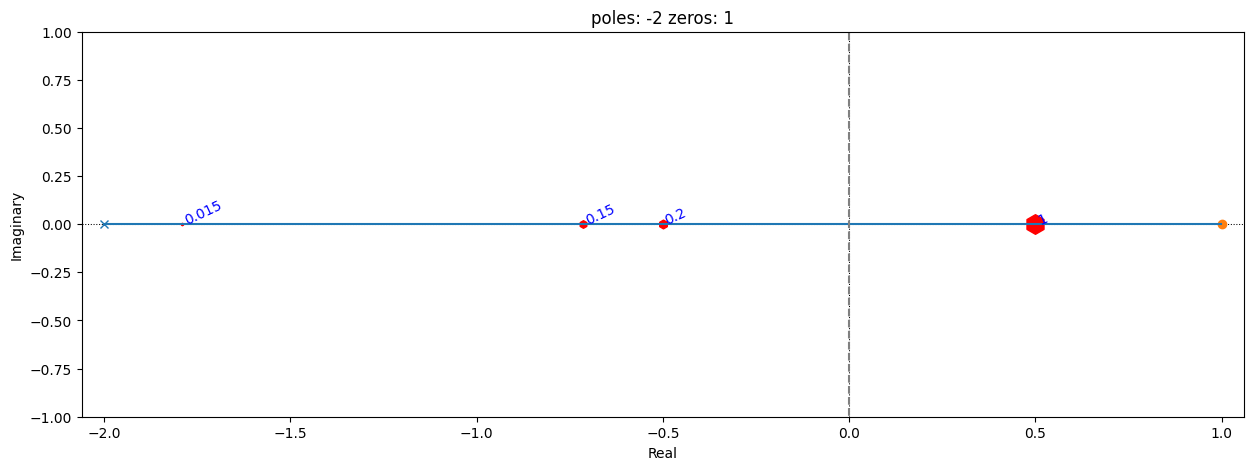

In [13]:
ol_tf = control.zpk([1], [-2], [5])
plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1], markersize_multiplier=200, title="poles: -2 zeros: 1",
    figsize=(15, 5),
     is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
2. Where does the branch start? Where does it end?
1. How do the poles "travel" as gain is increased?

A point at which a branch leaves the x-axis is a **breakaway point**.
A point at which a branch joins the x-axis is a **breakin point**.

<Axes: title={'center': 'poles: -4.0, -3.0  zeros: -10.0, -5.0'}, xlabel='Real', ylabel='Imaginary'>

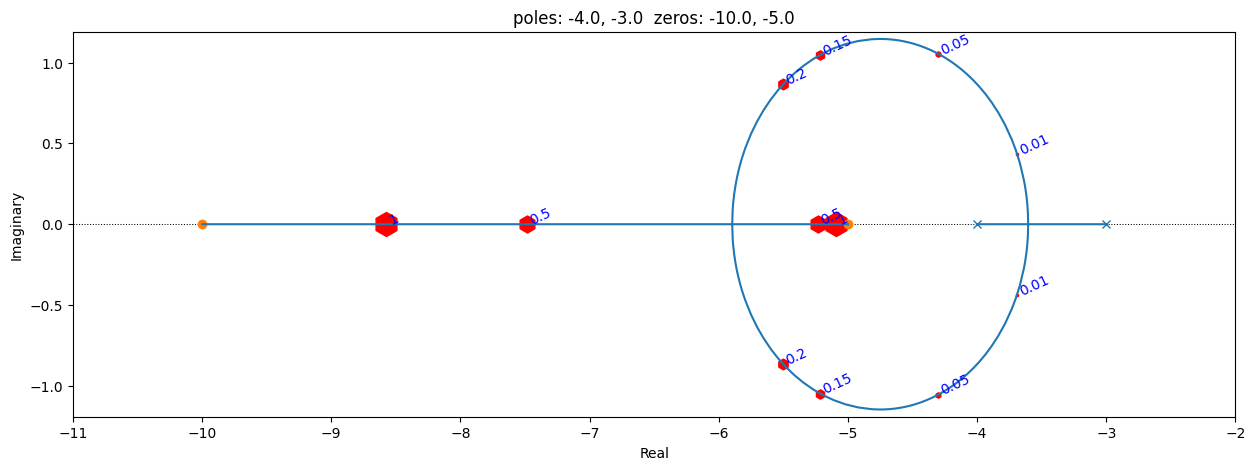

In [16]:
ol_tf = control.zpk([-5, -10], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 0.5, 1], markersize_multiplier=300,
    xlim=[-11, -2], figsize=[15, 5], is_annotate=True)

**Questions about this plot**
1. Where do the branches start?
2. Where do the branches end?
1. How many branches are there?
2. What is the breakaway point?
3. What is the breakin point?
4. How do the branches travel after the breakin point?

## Rules for root locus plots

### 1. Branches begin at open loop poles and terminate at open loop zeros or infinity.

$$H(s) = \frac{k_P G(s)}{1 + k_P G(s)}$$

Let $G(s) = \frac{N(s)}{D(s)}$, where $D(s) = 0$ is the open loop characteristic equation.
Then
$$H(s) = \frac{k_P N(s)}{D(s) + k_P N(s)}$$

**Questions**
1. What are the poles of $H(s)$ when $k_P$ is very small?
1. What are the poles of $H(s)$ when $k_P$ is very large?

### 2. The root locus plot is symmetric about the x-axis.

This follows from the fact that since transfer functions have real valued coefficients, complex solutions for $s$ must include their complex conjugates. Complex conjugates are symmetric w.r.t. the x-axis.

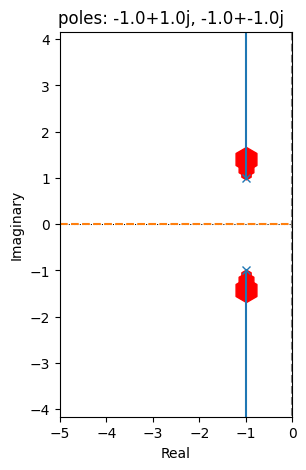

In [17]:
ol_tf = control.zpk([], [-1+1j, -1-1j], [1])
ax = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 5),
    xlim=[-5, 0], is_annotate=False)
ax.plot([-5, 0], [0, 0], linestyle="--")

### 3. Location of branches

Let $s$ be a point on the real axis. $s$ is a closed pole for some $k_P$ if there are an odd number of poles
and zeros to its right on the real axis

<Axes: title={'center': 'poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

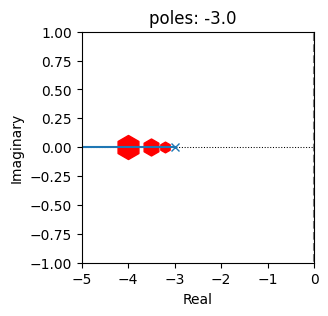

In [18]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3),
    xlim=[-5, 0], is_annotate=False)

<Axes: title={'center': 'poles: -4.0, -1.0  '}, xlabel='Real', ylabel='Imaginary'>

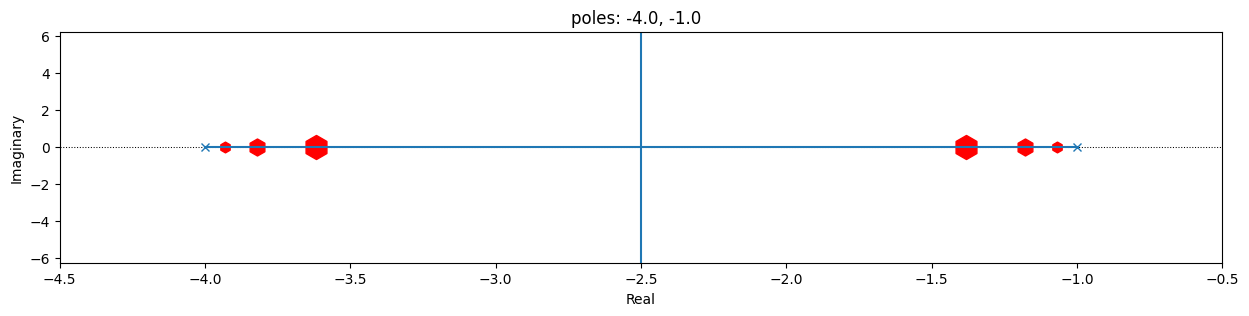

In [19]:
ol_tf = control.zpk([], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 3),
    xlim=[-4.5, -0.5], is_annotate=False)

<Axes: title={'center': 'poles: -4.0, -1.0  zeros: -2.0'}, xlabel='Real', ylabel='Imaginary'>

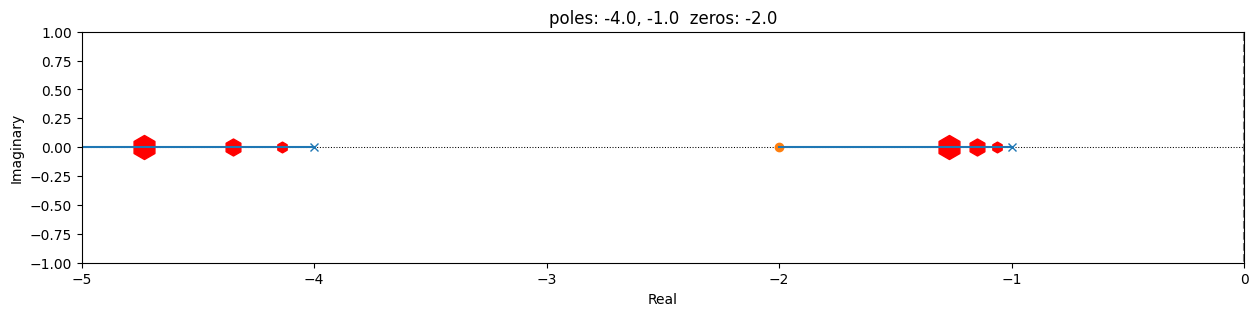

In [20]:
ol_tf = control.zpk([-2], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1],
    markersize_multiplier=300, figsize=(15, 3),
    xlim=[-5, 0], is_annotate=False)

**Proof**:
We know that for $s$ to be a pole, it must satisfy $1 + G(s) = 0$ or $G(s) = -1$.
$G(s) = \frac{\prod_m (s - z_m)}{\prod_n (s - p_n)}$.

For $G(s)$ to be negative, an odd number $z_m, p_n$ must be negtive.
That is an odd number of open loop poles and zeros must be to the right $s$.

### 4. Angle of asymptotes is $\alpha$ s.t. $(N_P - N_Z) \alpha = \pm 180 + k*360$

$N_P$ is the number of open loop poles; $N_Z$ is the number of open loop zeros.
$k \in \{0, \pm1, \pm2, \cdots \}$.


**Example 1**: $G(s) = \frac{1}{s + 3}$
* $N_P =1$, $N_Z = 0$.
* One asymptote. On x-axis to $-\infty$

<Axes: title={'center': 'poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

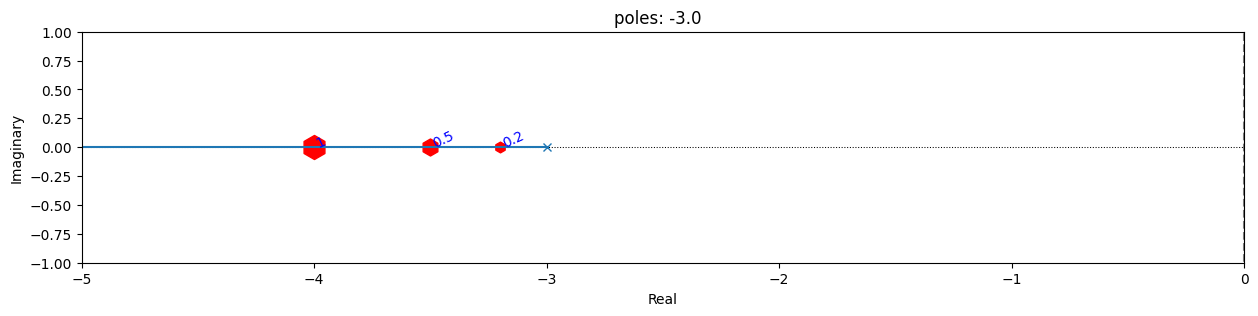

In [21]:
ol_tf = control.zpk([], [-3], [1])
_ = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 3),
    xlim=[-5, 0], is_annotate=True)

**Example 2**: $G(s) = \frac{s + 1}{s + 3}$
* $N_P =1$, $N_Z = 1$.
* No asymptote.

<Axes: title={'center': 'poles: -3.0  zeros: -1.0'}, xlabel='Real', ylabel='Imaginary'>

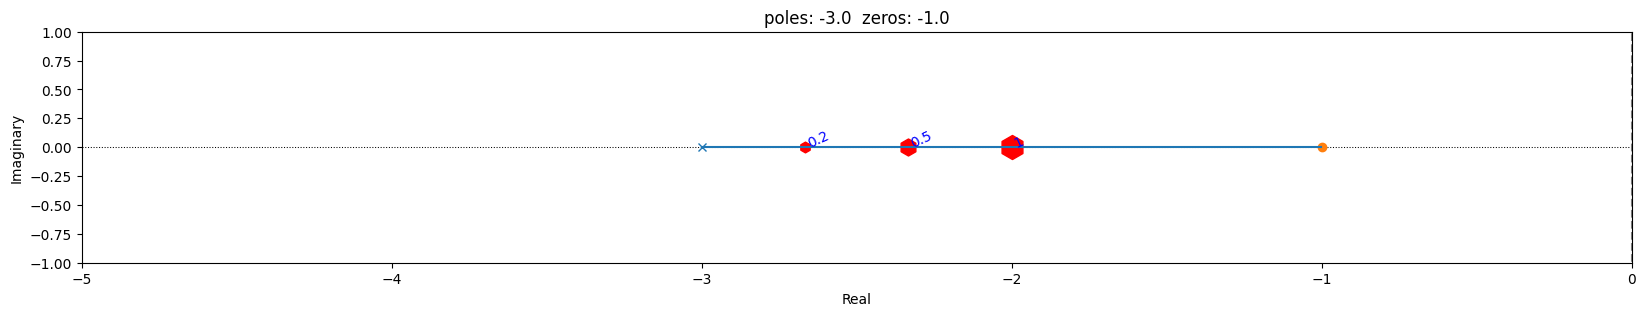

In [22]:
ol_tf = control.zpk([-1], [-3], [1])
_ = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(20, 3),
    xlim=[-5, 0], is_annotate=True)

**Example 3**: $G(s) = \frac{1}{(s + 1)(s + 3)(s + 4)}$
* $N_P =3$, $N_Z = 0$.
* Asymptotes
  * 180
  * 60
  * -60

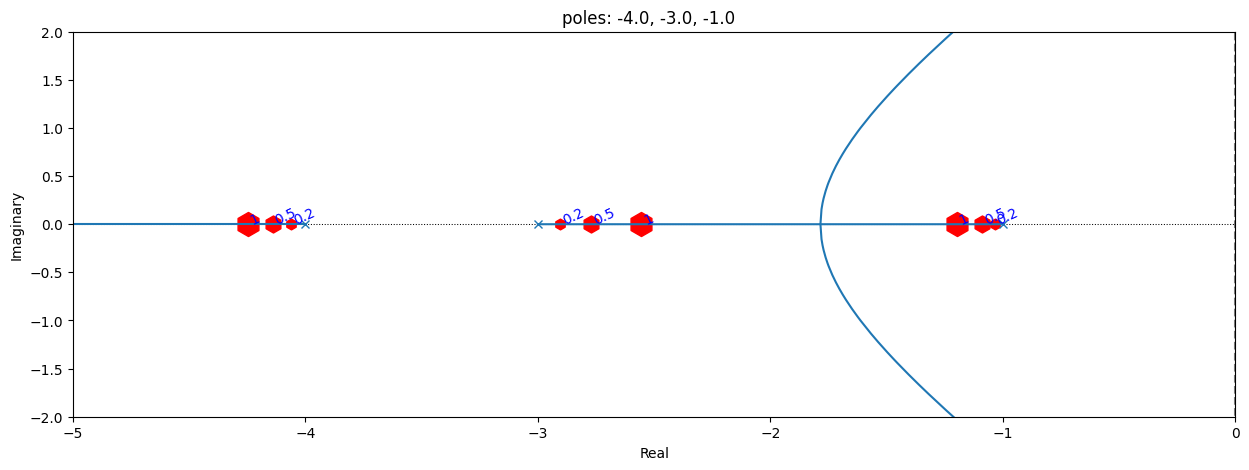

In [31]:
ol_tf = control.zpk([], [-1, -3, -4], [1])
_ = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 5),
    ylim=[-2, 2], xlim=[-5, 0], is_annotate=True)

**Proof**:
For large $s$, its angle with all poles and zeros is the same. We denote this angle by $\alpha$.
That is,
\begin{eqnarray}
\angle \left( \frac{N(s)}{D(s)} \right) & = & 180  \\
\alpha N_Z  - \alpha N_P  & = & 180\\
\alpha & = & -\frac{180}{N_P - N_Z}
\end{eqnarray}
Note that $\alpha + k 360 = \alpha$, for $k = 0, \pm1, \pm2, \cdots$.

Note: There is no asymptote if $N_P = N_Z$.

# Designing PID Control With Root Locus

**Design objective: Minimize the dominant.**

**Derivation**

Observe that we add a pole at 0 with I-control.

\begin{eqnarray}
C(s) & = & k_P + \frac{k_I}{s} + s k_D \\
& = & \frac{k_I + k_P s + k_D s^2}{s}
\end{eqnarray}

The zeros of $C(s)$ are
\begin{eqnarray}
k_I + k_P s + k_D s^2 & = & 0 \\
z_C & = & \frac{1}{2} \left( -k_P \pm \sqrt{k_P^2 - 4 k_I k_D} \right ), \\
\end{eqnarray}
where $z_C$ are the zeros introduced by the controller.

Let $z$ be the zeros of $G(s)$. Then, at high gain, the closed loop poles are at $max \{ z_C, z \}$.
Thus, in general, we want to choose $k_P, k_I, k_D$ so that we minimize $max~ z_C$.
This is done by:
* Choosing a large $k_P$.
* Choosing $k_I, k_D$ such that $k_P^2 = 4 k_I k_D$.

Let $G(s) = \frac{N(s)}{D(s)}$.
Then the open loop system with the controller is
\begin{eqnarray}
C(s)G(s) & = & \frac{k_I + k_P s + k_D s^2}{s} G(s) \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s + s D(s)}
\end{eqnarray}

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s D(s) + (k_I + k_P s + k_D s^2)   N(s)} \\
& = &  \frac{k_P(r_{IP} + s + r_{DP} s^2) N(s)}{s D(s) +  k_P(r_{IP} + s + r_{DP} s^2) N(s)} \\
\end{eqnarray}

* $r_{IP} = \frac{k_I}{k_P}$
* $r_{DP} = \frac{k_D}{k_P}$

# PI

**Open loop transfer function**
\begin{eqnarray}
C(s)G(s) & = & \frac{k_I + k_P s + k_D s^2}{s} G(s) \\
& = & \frac{(k_I + k_P s) N(s)}{s + s D(s)}
\end{eqnarray}

* Open loop zeros at $N(s) = 0$ and $-\frac{k_I}{k_P}$
* Open loop poles at $D(s) = 0$ and 0.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s D(s) + (k_I + k_P s + k_D s^2)   N(s)} \\
& = &  \frac{(k_I + k_P s) N(s)}{s D(s) +  (k_I + k_P s) N(s)} \\
\end{eqnarray}

**Closed loop transfer function**
* I-control ensures that DC gain is 1.

**Observations**
1. Need large $k_I$ and/or $k_P$ to move away from the pole at zero.
2. If $N(s)$ zeros are sufficiently negative, use large $k_I$ and/or $k_P$.
3. Note that negative open loop poles don't help us because we need large gains to address the pole at 0.

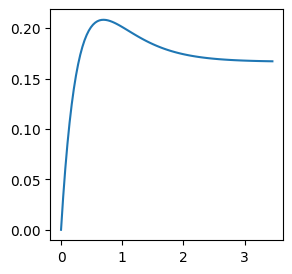

In [15]:
# Illustrative example
ol_tf = control.zpk([-1], [-2, -3], [1])
plotStep(ol_tf, figsize=(3,3))

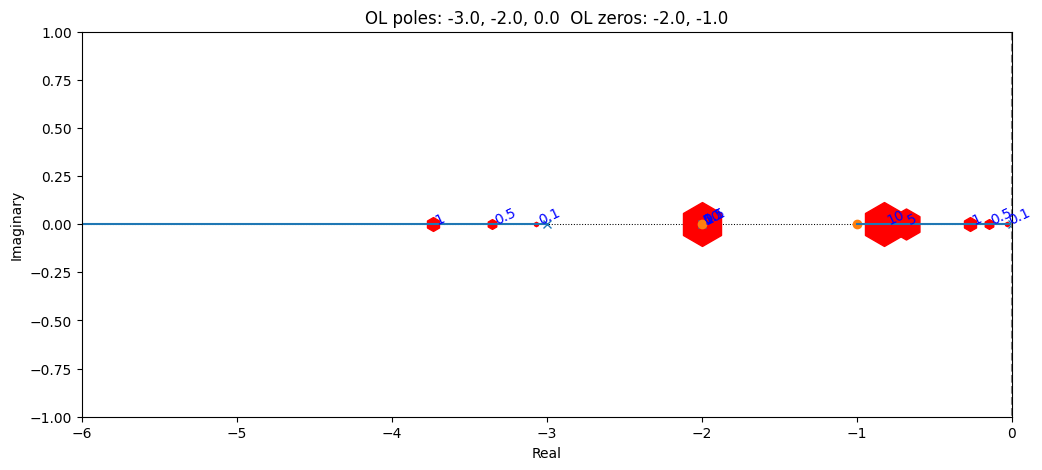

In [26]:
kP = 1
kI = 2
controller_tf = control.TransferFunction([kP, kI], [1, 0])
cl_tf = control.feedback(controller_tf*ol_tf)
_ = plotRootLocusWithGains(controller_tf*ol_tf, gains=[0.1, 0.5, 1, 5, 10], xlim=[-6, 0], figsize=[12, 5])

# PD

Not including I-control, means that we must consider DC gain. This can be done by having large values for $k_D$ and/or $k_P$.

# PID

**Approach**: Maximize $k_P$ since the asymptote for closed loop poles goes to $-\infty$

<Axes: title={'center': 'poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

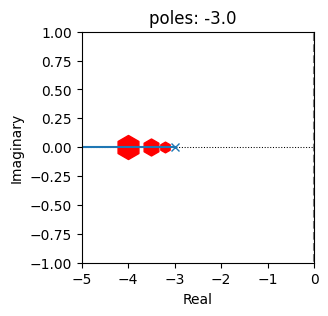

In [24]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3),
    xlim=[-5, 0], is_annotate=False)

**Approach**: Find $k_P$ at the breakaway point.

<Axes: title={'center': 'poles: -3, -4'}, xlabel='Real', ylabel='Imaginary'>

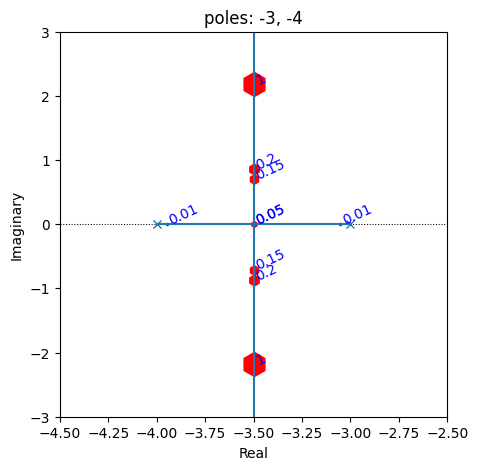

In [25]:
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300, title="poles: -3, -4",
    xlim=[-4.5, -2.5], ylim=[-3, 3], is_annotate=True)

**Approach**:
1. If $z > max(p_1, p_2)$, minimize $k_P$.
2. If $p_1 < z < p_2$, choose $k_P$ so that dominant closed loop pole is close to $z$.
3. If $z < p_1 < p_2$, choose $k_P$ at the breakin point.

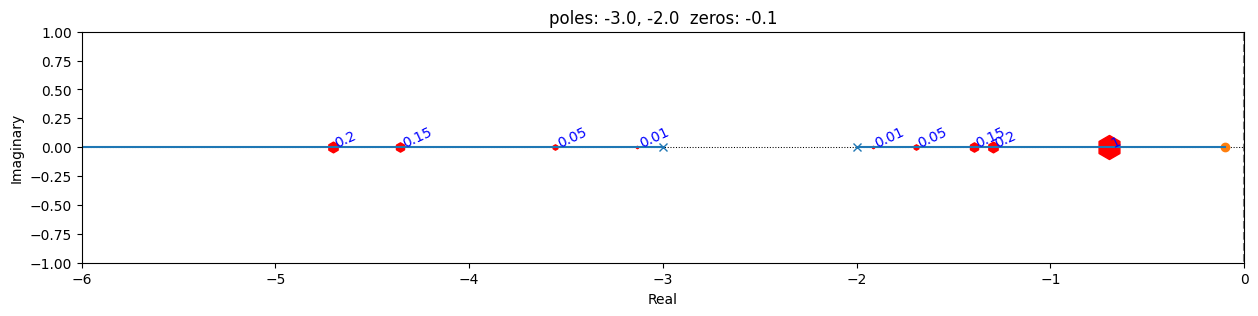

In [26]:
# Case 1: p1, p2 < z
ol_tf = control.zpk([-0.1], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-6, 0], figsize=(15, 3), is_annotate=True)

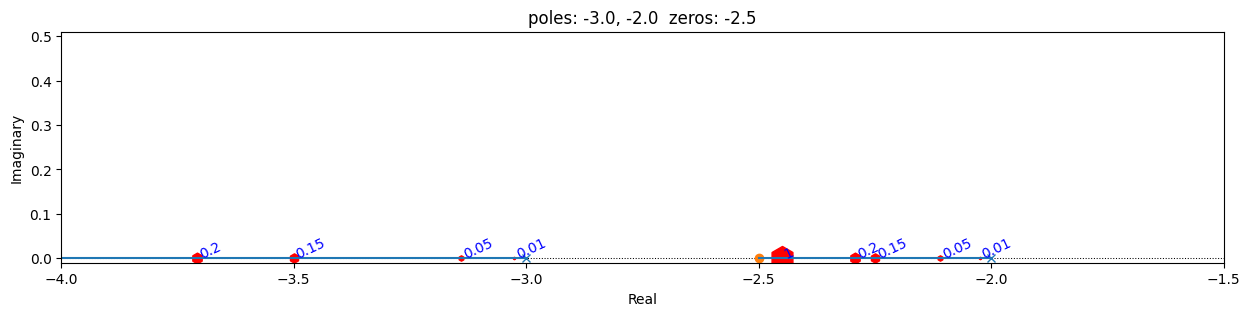

In [27]:
# Case 2: p1 < z < p2
ol_tf = control.zpk([-2.5], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-4, -1.5], figsize=(15, 3), is_annotate=True)

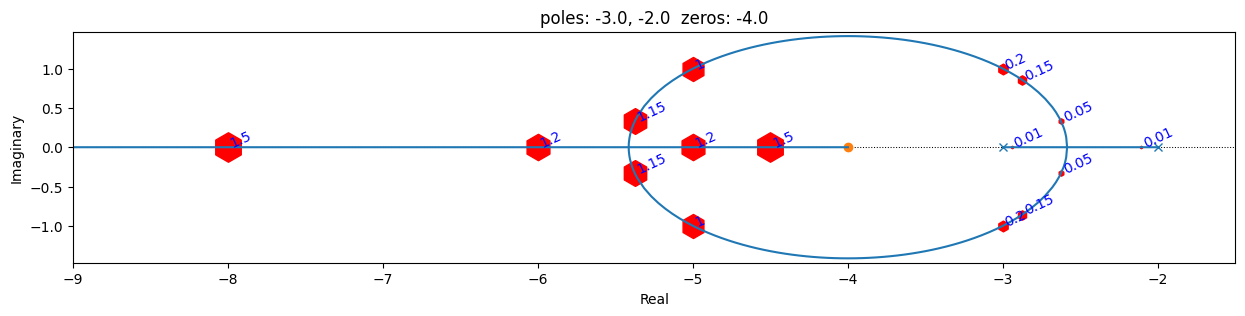

In [28]:
# Case 3: z < p1, p2
ol_tf = control.zpk([-4], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1, 1.15, 1.2, 1.5], markersize_multiplier=300,
    xlim=[-9, -1.5], figsize=(15, 3), is_annotate=True)